In [1]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as transforms

class HairMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image = Image.open(os.path.join(self.image_dir, image_name)).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, image_name)).convert('L')  # 单通道

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


In [2]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))  # 输出mask概率


In [3]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# 变换
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 数据集
dataset = HairMaskDataset(
    image_dir='/root/autodl-fs/skin_hair_dataset/alignment/photo with hair',
    mask_dir='/root/autodl-fs/skin_hair_dataset/alignment/mask',
    transform_img=transform_img,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()  # 二分类掩码

for epoch in range(20):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

# 保存模型
torch.save(model.state_dict(), "hair_seg_unet.pth")


Epoch 1, Loss: 0.5999
Epoch 2, Loss: 0.2689
Epoch 3, Loss: 0.1819
Epoch 4, Loss: 0.1797
Epoch 5, Loss: 0.1766
Epoch 6, Loss: 0.1738
Epoch 7, Loss: 0.1709
Epoch 8, Loss: 0.1684
Epoch 9, Loss: 0.1658
Epoch 10, Loss: 0.1603
Epoch 11, Loss: 0.1537
Epoch 12, Loss: 0.1438
Epoch 13, Loss: 0.1356
Epoch 14, Loss: 0.1251
Epoch 15, Loss: 0.1105
Epoch 16, Loss: 0.1031
Epoch 17, Loss: 0.0947
Epoch 18, Loss: 0.0842
Epoch 19, Loss: 0.0801
Epoch 20, Loss: 0.0876


/tmp/ipykernel_2095/4192023275.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hair_seg_unet.pth"))


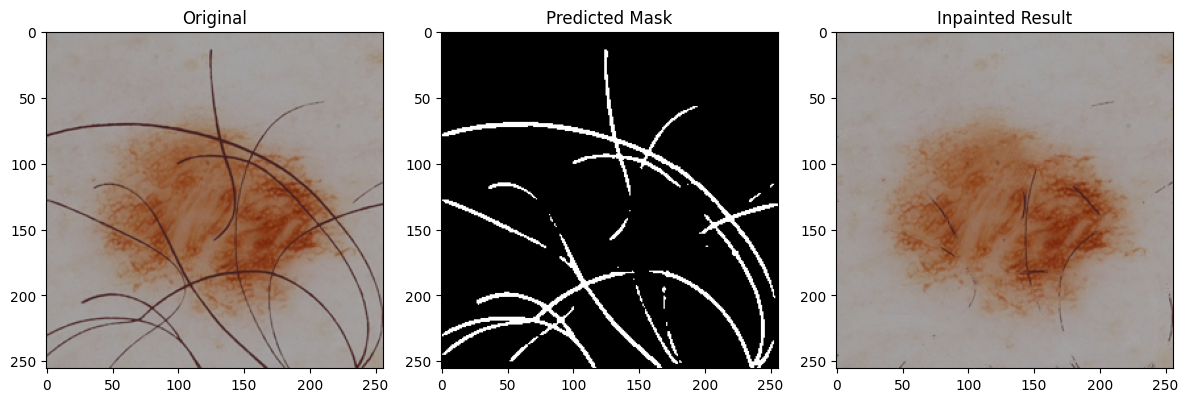

In [11]:
import cv2
import numpy as np
from PIL import Image

# 加载模型
model = UNet().to(device)
model.load_state_dict(torch.load("hair_seg_unet.pth"))
model.eval()

# 单张推理并修复
def inpaint_image(image_path, save_path=None):
    image = Image.open(image_path).convert("RGB").resize((256, 256))
    input_tensor = transform_img(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_mask = model(input_tensor).squeeze().cpu().numpy()
    binary_mask = (pred_mask > 0.5).astype('uint8') * 255  # 转为 0-255 掩码

    # OpenCV 修复
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    mask_cv = binary_mask.astype(np.uint8)
    inpainted = cv2.inpaint(image_cv, mask_cv, 3, cv2.INPAINT_TELEA)

    if save_path:
        cv2.imwrite(save_path, inpainted)
    return inpainted, image_cv, mask_cv

from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi

# ---------- 图像指标计算函数 ----------
def calculate_metrics(pred_img, gt_img):
    pred_img = pred_img.astype(np.float32) / 255.0
    gt_img = gt_img.astype(np.float32) / 255.0

    h, w = pred_img.shape[:2]
    win_size = min(7, h, w)
    if win_size % 2 == 0:
        win_size -= 1

    mse = mean_squared_error(gt_img, pred_img)
    psnr = peak_signal_noise_ratio(gt_img, pred_img, data_range=1.0)
    ssim = structural_similarity(gt_img, pred_img, data_range=1.0, channel_axis=2, win_size=win_size)
    uqi_val = uqi(gt_img, pred_img)

    return mse, psnr, ssim, uqi_val


# 示例使用
img_path = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair/ISIC2019_0000461.jpg"
output_path = "/root/autodl-fs/inpaint_result_0461.png"
inpainted, original, mask = inpaint_image(img_path, output_path)

# 可视化结果
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title("Predicted Mask")
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)); plt.title("Inpainted Result")
plt.tight_layout(); plt.show()


In [12]:
# ---------- 批量评估 ----------
photo_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
gt_dir = "/root/autodl-fs/skin_hair_dataset/alignment/oryginal"  # 原图（无毛发）

image_list = sorted([f for f in os.listdir(photo_dir) if f.endswith('.jpg')])

total_mse, total_psnr, total_ssim, total_uqi = 0, 0, 0, 0
valid_count = 0

for img_name in image_list:
    try:
        # 推理去毛发图像
        photo_path = os.path.join(photo_dir, img_name)
        inpainted, original, _ = inpaint_image(photo_path)

        # 获取 ground-truth（无毛发图）
        gt_path = os.path.join(gt_dir, img_name)
        if not os.path.exists(gt_path):
            print(f"❌ ground-truth 缺失: {img_name}")
            continue
        gt_img = cv2.imread(gt_path)
        gt_img = cv2.resize(gt_img, (256, 256))

        # 计算指标
        mse, psnr, ssim, uqi_val = calculate_metrics(inpainted, gt_img)
        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim
        total_uqi += uqi_val
        valid_count += 1

        print(f"✅ {img_name}  |  MSE: {mse:.4f}, PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, UQI: {uqi_val:.4f}")
    except Exception as e:
        print(f"⚠️ 处理失败: {img_name} | {str(e)}")

# ---------- 平均指标输出 ----------
if valid_count > 0:
    print("\n📊 平均指标:")
    print(f"  MSE  : {total_mse / valid_count:.6f}")
    print(f"  PSNR : {total_psnr / valid_count:.2f} dB")
    print(f"  SSIM : {total_ssim / valid_count:.4f}")
    print(f"  UQI  : {total_uqi / valid_count:.4f}")
else:
    print("❌ 没有成功评估任何图像")


✅ ISIC2017_0000026.jpg  |  MSE: 0.0015, PSNR: 28.14, SSIM: 0.9698, UQI: 0.9997
✅ ISIC2017_0000081.jpg  |  MSE: 0.0010, PSNR: 29.79, SSIM: 0.8273, UQI: 0.9984
✅ ISIC2017_0000082.jpg  |  MSE: 0.0002, PSNR: 36.99, SSIM: 0.9351, UQI: 0.9981
✅ ISIC2017_0000147.jpg  |  MSE: 0.0006, PSNR: 32.00, SSIM: 0.9135, UQI: 0.9979
✅ ISIC2017_0000150.jpg  |  MSE: 0.0003, PSNR: 35.88, SSIM: 0.9156, UQI: 0.9986
✅ ISIC2017_0000151.jpg  |  MSE: 0.0002, PSNR: 38.20, SSIM: 0.9474, UQI: 0.9985
✅ ISIC2017_0000152.jpg  |  MSE: 0.0006, PSNR: 32.48, SSIM: 0.8881, UQI: 0.9967
✅ ISIC2017_0000153.jpg  |  MSE: 0.0002, PSNR: 37.55, SSIM: 0.9278, UQI: 0.9996
✅ ISIC2017_0000154.jpg  |  MSE: 0.0004, PSNR: 34.43, SSIM: 0.9021, UQI: 0.9990
✅ ISIC2017_0001148.jpg  |  MSE: 0.0002, PSNR: 37.89, SSIM: 0.9519, UQI: 0.9995
✅ ISIC2017_0012137.jpg  |  MSE: 0.0003, PSNR: 35.66, SSIM: 0.9223, UQI: 0.9992
✅ ISIC2017_0015079.jpg  |  MSE: 0.0005, PSNR: 33.06, SSIM: 0.8702, UQI: 0.9961
✅ ISIC2019_0000171.jpg  |  MSE: 0.0017, PSNR: 27.73,